# Processos estocásticos em Física

Em alguns problemas de física, podemos ter eventos com uma determinada probabilidade $P$ de ocorrer. Por exemplo, um dado de 6 lados tem probabilidade $P = \frac 1 6$ de cair com o lado 6 para cima. A probabilidade é a mesma para qualquer lado. Num outro exemplo, uma moeda viciada pode ter probabilidade $P = 0.2$ de dar cara. Como podemos simular isso num computador?

## Modelando probabilidades discretas
Suponha que temos um evento que ocorre com probabilidade uniforme, gerando um valor $r$ entre $a$ e $b$. Neste caso, a *função distribuição de probabilidade* (PDF) tem a aparência mostrada abaixo.

![PDF uniforme de a até b, com uma região selecionada, interna e menor, c até d.](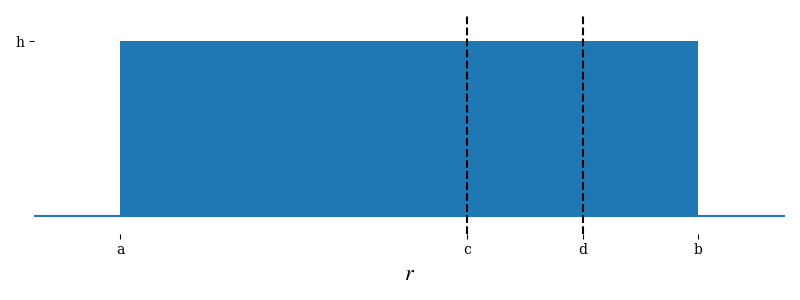
)

Uma região menor entre $c$ e $d$ está selecionada. Perguntamos: qual a probabilidade do valor $r$ ocorrer entre $c$ e $d$?

Para calcular esta probabilidade formalmente, precisamos integrar a PDF entre os valores que estamos interessados. Porém, sabemos que a probabilidade é uniforme, e então, a probabilidade é simplesmente proporcional à razão entre a área do retângulo delimitado por $c$ e $d$ e do retângulo delimitado por $a$ e $b$. Isto é,

\begin{align}
P(c < r < d) &= \frac{(d - c)h}{(b - a)h} \\
&= \frac{d - c}{b - a}.
\end{align}

Podemos perceber que a probabilidade é proporcional ao tamanho dos segmentos. No nosso gerador de números pseudo-aleatórios (PRNG), conseguimos um valor com distribuição uniforme entre $a=0$ e $b=1$. Neste caso, a probabilidade é simplesmente $P(c < r < d) = d - c$.

## Simulando uma moeda viciada

Voltando ao exemplo da moeda viciada, que cai com *cara* pra cima em 20% dos lançamentos. Como simular este problema usando o que vimos acima?

Como temos um PRNG uniforme que gera valores entre 0 e 1, precisamos de dois valores $c$ e $d$ tal que

$$
P(c < r < d) = d - c = 0{,}2.
$$

Colhemos um número $r$ do PRNG. Se $r$ estiver entre $c$ e $d$, dizemos que a moeda deu cara. Caso contrário, coroa. Quaisquer $c$ e $d$ entre 0 e 1 servem, desde que $d - c = 0{,}2$. Um jeito simples é fazer $c=0$ e $d=0{,}2$, e assim, podemos escrever em código:

In [ ]:
import numpy as np
d = 0.2
r = np.random.rand()
if r < d:
    print('cara')
else:
    print('coroa')

Execute a célula acima muitas vezes e veja que na maioria das vezes é impressa a palavra `coroa`. Esperamos que o resultado seja coroa 20% das vezes. Uma forma de verificar isto é contando quantas vezes sai cara ou coroa, com $N$ lançamentos da moeda.

In [ ]:
np.random.seed(1234)

def moeda_viciada():
    p = 0.2
    r = np.random.rand()
    if r < p:
        return 'cara'
    else:
        return 'coroa'

In [ ]:
# Vamos contar quantas vezes sai cara ou coroa.
cara = 0
coroa = 0
N = 100

for _ in range(N):
    # O índice aqui é irrelevante, chamamos a variável do laço
    # de _ para indicar isso. Lançamos a moeda N vezes e contamos
    # quantas vezes caiu em cada lado.
    if moeda_viciada() == 'cara':
        cara += 1
    else:
        coroa += 1

In [ ]:
# A probabilidade estimada para cara ou coroa é
# a fração de vezes que caiu em cada lado.
p_cara = cara / N
p_coroa = coroa / N

print(f'cara  (%): {p_cara * 100:.1f}%')
print(f'coroa (%): {p_coroa * 100:.1f}%')

Faremos isso para vários valores crescentes de $N$, e veremos se o resultado faz sentido.

In [ ]:
np.random.seed(1234)

def prob_moeda(N):
    cara = 0
    coroa = 0
    for _ in range(N):
        if moeda_viciada() == 'cara':
            cara += 1
        else:
            coroa += 1
    p_cara = cara / N
    p_coroa = coroa / N
    return p_cara, p_coroa

In [ ]:
# M experimentos, com números de lançamentos
# N crescentes.
M = 100
    
# Valores da probabilidade estimada em função de N.
p_cara = np.zeros(M)
p_coroa = np.zeros(M)

# Valores de N espaçados em
# escala logarítmica (N = 10¹ até N = 10⁵).
N_array = np.logspace(1, 5, M)

for k, N in enumerate(N_array):
    # A saída de logspace() é um número float.
    # Precisamos de int para o range().
    N = int(N)
    p_cara[k], p_coroa[k] = prob_moeda(N)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'

In [ ]:
fig, ax = plt.subplots()
ax.plot(N_array, p_cara, label='cara')
ax.plot(N_array, p_coroa, label='coroa')

# Valores das probabilidades reais.
ax.axhline(0.2, ls = '--', lw=1)
ax.axhline(0.8, ls = '--', lw=1)

ax.set_xscale('log')
ax.set_xlabel('N')
ax.legend()
plt.show()

Conforme o número de lançamentos aumenta, a fração de vezes que o resultado é cara se aproxima do valor da probabilidade definida no modelo,

$$
P_\text{cara} \cong P(c < r < d) = 0{,}2.
$$

O cálculo da probabilidade de dar coroa é trivial, pois sabemos que quando não sai cara, sai coroa. Neste caso, $P_\text{cara} + P_\text{coroa} = 1$, logo $P_\text{coroa} \cong 0.8$.

### Exemplo: caminhada aleatória

Uma partícula num gás ou fluido qualquer recebe um bombardeio de colisões com as moléculas deste meio. Se a partícula for suficientemente pequena, essas colisões conseguem alterar o movimento da partícula, fazendo-a percorrer um caminho aleatório, comnhecido como *movimento browniano*.

Uma forma de aproximar o movimento browniano é através da *caminhada aleatória*, com passos discretos. Quando o tamanho do passo é suficientemente pequeno, a caminhada aleatória se aproxima do movimento browniano. Vamos fazer uma simulação, onde uma partícula pode ocupar posições discretas dadas pelas coordenadas $(i, j)$, com $i$ e $j$ inteiros, começando na posição $i=j=0$. A cada passo, escolhemos aleatoriamente se a partícula vai para cima, baixo, esquerda ou direita, dando um salto unitário naquela direção.

Faremos isso da mesma forma que no caso da moeda. Cada direção tem uma probabilidade, $P_\text{cima}$, $P_\text{baixo}$, $P_\text{esquerda}$ e $P_\text{direita}$. Vamos admitir que as probabilidades são iguais, com valor $P = \frac 1 4 = 0.25$.

In [ ]:
np.random.seed(1234)

# Passos de tempo.
N = 100

# Posições da partícula.
x = np.zeros(N, dtype='int32')
y = np.zeros(N, dtype='int32')

# Posição inicial.
x[0] = 0
y[0] = 0

# Iterando o movimento.
for t in range(1, N):
    # Número aleatório no intervalo [0, 1).
    r = np.random.rand()
    if 0 <= r < 0.25:
        # Cima
        dx = 0
        dy = 1
    elif 0.25 <= r < 0.5:
        # Baixo
        dx = 0
        dy = -1
    elif 0.5 <= r < 0.75:
        # Direita
        dx = 1
        dy = 0
    else:
        # Esqzuerda
        dx = -1
        dy = 0
    
    x[t] = x[t - 1] + dx
    y[t] = y[t - 1] + dy

Depois de $N$ passos, temos o caminho percorrido pela partícula, com posições sucessivas $(x_i, y_i)$. Abaixo temos o gráfico do caminho percorrido.

In [ ]:
fig, ax = plt.subplots()
# As variáveis l e b são guardadas para a
# animação na célula a seguir.

# Linha contendo o caminho.
# A vírgula é necessária porque ax.plot() retorna
# uma lista de linhas. Neste plot, temos uma lista
# de apenas um elemento (somente uma linha desenhada),
# logo o lado esquerdo é uma tupla de um elemento só.
# Veja https://pythonhelp.wordpress.com/2013/01/10/desempacotamento-de-tupla/
l, = ax.plot(x, y)

# Círculo indicando a posição final.
b, = ax.plot(x[-1], y[-1], 'ro')

# Ponto de partida.
ax.plot(x[0], y[0], 'rx', alpha=0.5)
plt.show()

Um gráfico estático não mostra bem a natureza do movimento. Vamos fazer uma animação.

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Modificando o conteúdo das linhas do gráfico.
def animate(i):
    # Desenha a linha até o instante i.
    l.set_data(x[:i+1], y[:i+1])
    # Desenha o círculo na posição atual no instante i.
    b.set_data([x[i]], [y[i]])

ani = FuncAnimation(fig, animate, frames=N)
HTML(ani.to_jshtml())

### Exercício

Refaça o problema da caminhada aleatória apenas em uma dimensão. Considere 1000 partículas independentes, evoluindo 2000 passos de tempo, com passos unitários. Sugestão: guarde a história das partículas num array como este:

In [ ]:
Nt = 2000
Np = 1000
x = np.zeros((Nt, Np), dtype='int32')

**a.** Faça a simulação normalmente, sem limites no tamanho da caixa. Para verificar se a simulação funcionou, desenhe o gráfico da posição de 5 partículas quaisquer em função do tempo. Se você usou a forma acima, a história de uma partícula individual pode ser acessada tomando uma fatia do array `x`, por exemplo, `x[:, 4]` é um array que contém a história da quinta partícula, em um array de 2000 elementos.

**b.** Calcule a média $\bar{x} = \langle x \rangle$ e o desvio padrão $\sigma = \sqrt{\langle (x - \bar{x})^2 \rangle}$ da posição das partículas a cada instante de tempo. Para tomar a posição de todas as partículas num determinado instante `t`, faça `x[t, :]`, isto irá retornar um array de 1000 elementos.

Faça o gráfico de $\bar{x}(t)$ e $\sigma(t)$. Como o passo de tempo é unitário, os instantes de tempo podem ser feitos, por exemplo, como `tt = np.arange(Nt)`. No mesmo gráfico, desenhe a função $f(t) = \sqrt t$, e veja como esta curva se compara com $\sigma(t)$.

### Teorema central do limite

Este comportamento do $\sigma$ é um fenômeno chamado de *difusão*. De fato, segundo o teorema central do limite ([video obrigatório do 3Blue1Brown](https://www.youtube.com/watch?v=zeJD6dqJ5lo)), a soma de muitas variáveis aleatórias gera uma distribuição normal, que neste problema vai alargando (maior $\sigma$) com o passar do tempo.

Abaimo temos histogramas das posições das partículas nos instantes $t = 100, 500$ e $1999$. Essas distribuições se aproximam de gaussianas dadas por

$$
P(x) = \frac{\exp \left({-\frac{x^2}{t}}\right)}{\sqrt{2 \pi t}}.
$$

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(-100, 100, 1000)

fotos=[(100, 'r'), (500, 'g'), (1999, 'b')]

for t, color in fotos:
    ax.hist(x[t, :], range=[-100, 100], color=color,
            histtype='step', bins=100, density=True)
    P = np.exp(-xx**2 / t) / np.sqrt(2 * np.pi * t)
    ax.plot(xx, P, '-', color=color, label=f'$t={t}$')


ax.set_xlabel('x')
ax.grid(True)
ax.legend()
plt.show()

Modifique o número de partículas (sem exagerar) e veja o que acontece com o gráfico.